# JupyterLite Workflow

In diesem Repository geht es darum, einen Workflow für JupyterLite zu testen, der es erlaubt, lokal zu entwickeln mit VSCode resp. JupyterLab und anschliessend die Notebooks via JupyterLite im Browser auszuführen.

In einem zweiten Schritt soll der Build-Prozess via GitHub Actions automatisiert werden und die Notebooks anschliessend auf GitHub Pages gehostet werden.

## Standard Python

In [1]:
print("Hallo World")

Hallo World


## Importing Modules

In [2]:
%pip install rdflib

import requests
import pandas as pd
from rdflib import Graph, Namespace, URIRef, Literal, RDF
from IPython.display import HTML, display
from ext.rdf import query_endpoint, query_ttl, display_result


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Pandas

In [3]:
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6]
})

display(df)

,A,B
0,1,4
1,2,5
2,3,6


## Requests

In [4]:
response = requests.get('https://api.github.com')
print(response.status_code)

200


## rdflib

In [5]:
# 1. Create a new RDF graph
g = Graph()

# 2. Define a namespace (like a prefix in Turtle)
EX = Namespace("http://example.org/")

# 3. Add some triples (subject, predicate, object)
g.add((EX.Alice, RDF.type, EX.Person))
g.add((EX.Alice, EX.name, Literal("Alice")))
g.add((EX.Alice, EX.age, Literal(30)))
g.add((EX.Bob, RDF.type, EX.Person))
g.add((EX.Bob, EX.knows, EX.Alice))

# 4. Serialize the graph in Turtle format
print("Graph in Turtle syntax:")
print(g.serialize(format="turtle"))

# 5. Run a SPARQL query
q = """
PREFIX ex: <http://example.org/>
SELECT ?person ?name
WHERE {
  ?person a ex:Person ;
          ex:name ?name .
}
"""

print("\nSPARQL query results:")
for row in g.query(q):
    print(f"{row.person} — {row.name}")

Graph in Turtle syntax:
@prefix ns1: <http://example.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ns1:Bob a ns1:Person ;
    ns1:knows ns1:Alice .

ns1:Alice a ns1:Person ;
    ns1:age 30 ;
    ns1:name "Alice" .



SPARQL query results:
http://example.org/Alice — Alice


## Local Modules

Achtung: Wenn lokale Module eigene Dependencies haben, müssen diese zuerst in einer Zelle im Jupyter Lite Notebook installiert resp. importiert werden - auch wenn diese im lokalen Modul bereits importiert werden.

In [6]:
query = """

SELECT * WHERE {
  ?s ?p ?o .
} LIMIT 10

"""

df = query_endpoint("https://ld.admin.ch/query", query)

display_result(df)

,s,p,o
0,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
1,http://www.w3.org/1999/02/22-rdf-syntax-ns#Property,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
2,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
3,http://www.w3.org/1999/02/22-rdf-syntax-ns#rest,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
4,http://www.w3.org/1999/02/22-rdf-syntax-ns#nil,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
5,http://www.w3.org/1999/02/22-rdf-syntax-ns#List,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
6,http://www.w3.org/1999/02/22-rdf-syntax-ns#HTML,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
7,http://www.w3.org/1999/02/22-rdf-syntax-ns#langString,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
8,http://www.w3.org/1999/02/22-rdf-syntax-ns#PlainLiteral,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#
9,http://www.w3.org/1999/02/22-rdf-syntax-ns#Statement,http://www.w3.org/2000/01/rdf-schema#isDefinedBy,http://www.w3.org/1999/02/22-rdf-syntax-ns#


In [7]:
ttl = """

@prefix ex: <http://example.org/> .
ex:Alice a ex:Person ;
         ex:name "Alice" ;
         ex:age 30 .
ex:Bob a ex:Person ;
        ex:knows ex:Alice .

"""

query = """
PREFIX ex: <http://example.org/>
SELECT ?person ?name
WHERE {
  ?person a ex:Person ;
          ex:name ?name .
}
"""

df = query_ttl(ttl, query)

display_result(df)

,person,name
0,http://example.org/Alice,Alice


## Municipalities

In [8]:
query = """

PREFIX vl: <https://version.link/>
PREFIX admin: <https://schema.ld.admin.ch/>
PREFIX schema: <http://schema.org/>

SELECT ?canton ?cantonName ?numberOfMunies
FROM <https://lindas.admin.ch/fso/register>
WHERE {
    
    ?canton schema:legalName ?cantonName.

    {
        SELECT ?canton (COUNT(?muni) AS ?numberOfMunies)
        WHERE {

            ?muni a admin:PoliticalMunicipality;
                a vl:Identity;
                schema:isPartOf/schema:isPartOf ?canton.

            MINUS {?muni a vl:Deprecated}

        } GROUP BY ?canton
    
    }
} ORDER BY DESC(?numberOfMunies)

"""

df = query_endpoint("https://lindas.int.cz-aws.net/query", query)

display_result(df)

,canton,cantonName,numberOfMunies
0,https://ld.admin.ch/canton/2,Bern / Berne,335
1,https://ld.admin.ch/canton/22,Vaud,300
2,https://ld.admin.ch/canton/19,Aargau,197
3,https://ld.admin.ch/canton/1,Zürich,160
4,https://ld.admin.ch/canton/23,Valais / Wallis,122
5,https://ld.admin.ch/canton/10,Fribourg / Freiburg,121
6,https://ld.admin.ch/canton/11,Solothurn,106
7,https://ld.admin.ch/canton/18,Graubünden / Grigioni / Grischun,100
8,https://ld.admin.ch/canton/21,Ticino,100
9,https://ld.admin.ch/canton/13,Basel-Landschaft,86


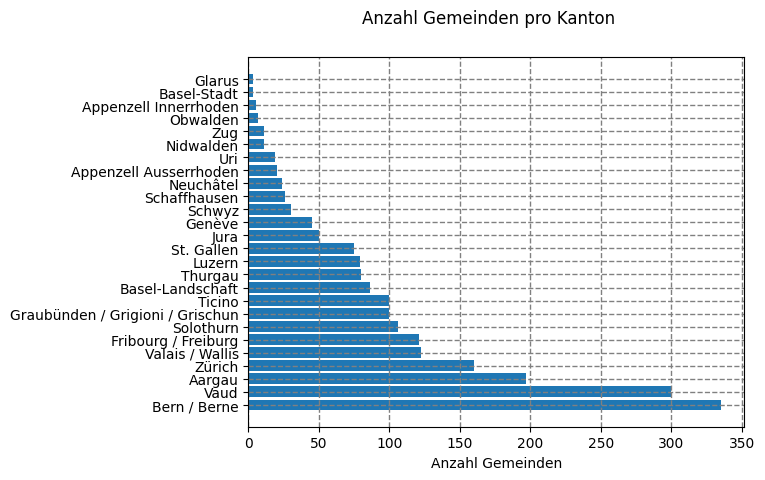

In [9]:
from matplotlib import pyplot as plt

plt.barh(df["cantonName"], df["numberOfMunies"])
plt.suptitle("Anzahl Gemeinden pro Kanton")
plt.xlabel("Anzahl Gemeinden")
plt.grid(color = "grey", linestyle = "--", linewidth=1)
plt.show()